In [1]:
import numpy as np
import open3d as o3d
from tools import load, project, camera
# auto reload packages
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Visualize point cloud from lidar data
## Load Data
First go to the [IGN geoservice](https://geoservices.ign.fr/lidarhd) website.  
Select the desired tiles in the interactive map and download the url list as a txt file.  

In [102]:
datadir = "./data/MNS/"
# can take time, needed only once
#load.download_and_load(datadir, datadir+"liste_dalle_extended.txt", 10000)
#pc = load.load_pcd(datadir, "saved_terrain_customname")

In [109]:
lat, lon = 44.5451545715, 4.2165341377
load.download_from_eio(datadir, 'test', lat, lon)

make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
cp SRTM3.vrt SRTM3.948634e474e341f5bd99ca5b9300f91f.vrt
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 3.9008291696998154 44.7701568215225 4.532239105700185 44.3201523214775 SRTM3.948634e474e341f5bd99ca5b9300f91f.vrt /media/nicod/Documents/D4G/pyronear/lidar/data/MNS/test.tiff
rm -f SRTM3.948634e474e341f5bd99ca5b9300f91f.vrt
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
File ./data/MNS/test.xyz ready.


In [110]:
# import pcd file
pc = o3d.io.read_point_cloud(datadir+'brison.xyz') # datadir+"saved_terrain_15x15_extended.pcd"
pc2 = o3d.io.read_point_cloud(datadir+"saved_terrain_15x15_extended.pcd")

In [111]:
# display test
o3d.visualization.draw_geometries([pc])

## Define view point

In [67]:
lat, lon = 44.5451545715, 4.2165341377 # brison
#lat, lon =  35.18057, -111.65288 # test1

altitude=785 # 2109
view_point = project.to_lambert93(lat, lon, altitude)

In [159]:
# Add a sphere at view point
sphere = o3d.geometry.TriangleMesh.create_sphere(radius=15)
sphere.translate(view_point)

TriangleMesh with 762 points and 1520 triangles.

In [68]:
width = 1280
height = 720
# read camera parameters
parameters = o3d.io.read_pinhole_camera_parameters("ScreenCamera_viewpoint.json")
# change intrinsic and extrinsinc matrices in this file
# for example, the following function compute the focal length in pixels from the camera parameters
camera.get_focal_length_px(4, 1/2.49)

(914.206475584154, 914.2064755841538)

In [11]:
# example to set the camera to the registered location
camera.visualize([pc, sphere], parameters)

## Set camera actions

Register camera position (to do once per viewpoint):
- place camera vertically to have viewpoint around the center (eventually use U)
- use L to lock the viewpoint direction
- use T to translate until viewpoint is reached
- use P to save the camera parameters

Place camera to viewpoint:
- use V to set view
- use left/right arrows to rotate until desired view is obtained
- use D to save depth parameters

In [ ]:
key_to_callback = camera.callbacks(parameters, view_point)
o3d.visualization.draw_geometries_with_key_callbacks([pc, sphere], key_to_callback, width=width, height=height)

# Extract skyline
Based on [A New Method of Improving the Azimuth in Mountainous Terrain by Skyline Matching](https://link.springer.com/article/10.1007/s41064-020-00093-1) by Nagy Balázs (2019)

In [154]:
spherical = project.array_cartesian_to_spherical((pc+pc2).points, view_point)
angles = project.get_deg_angles(spherical)

In [155]:
skyline = project.get_skyline(angles)
n=3
smooth_skyline = np.convolve(skyline, np.ones(n)/n, mode='valid')

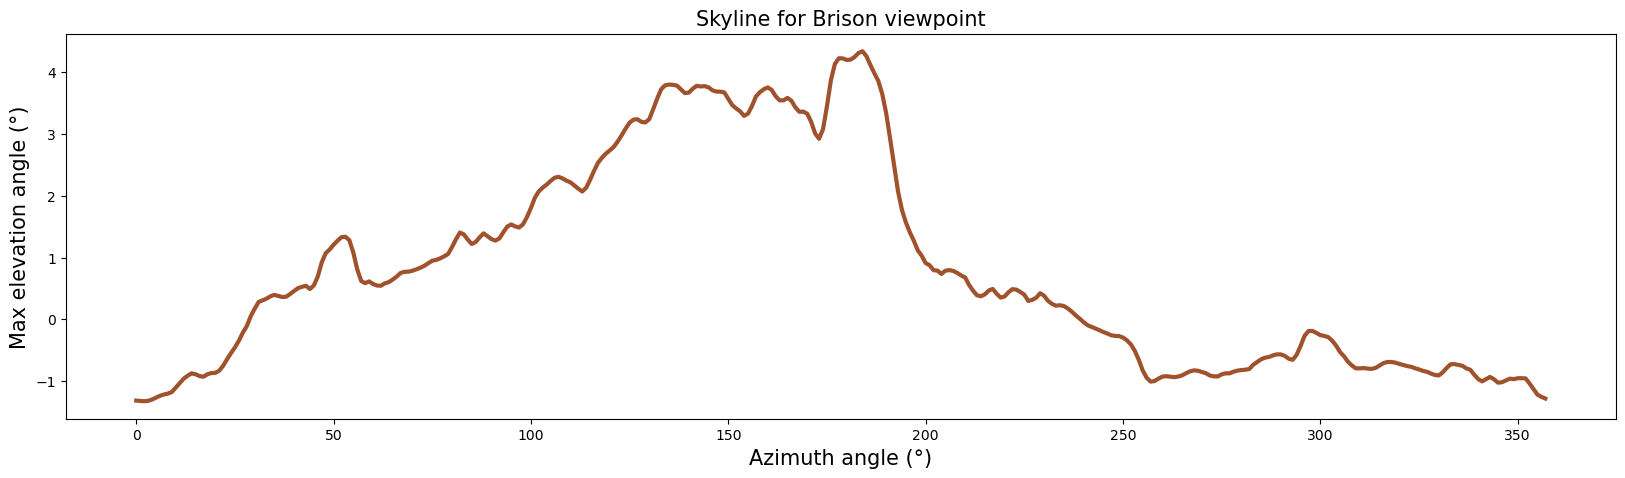

In [156]:
project.plot_skyline(smooth_skyline, 'Skyline for Brison viewpoint')

## Project skyline on terrain
![](./data/plots/skyline_terrain.png)

In [131]:
max_z = np.max(np.asarray(pc.points)[:,2])
skyline_points = project.skyline_to_cartesian(spherical, angles, skyline, view_point, max_z)

In [57]:
camera.save_skyline_with_terrain(pc, skyline_points, './data/plots/skyline_terrain_large.png')

Image saved at ./data/plots/skyline_terrain_large.png


## Compare with image skyline

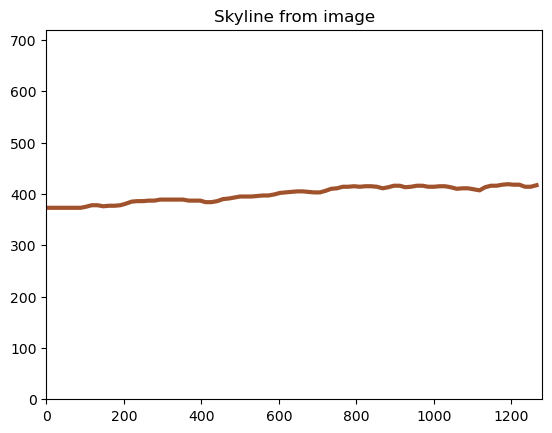

In [131]:
fov = 87 # field of view
image_skyline = load.load_skyline('data/horizon/horizon_contour_b4.npy', fov, width, height, plot=True) # axis-skydomenau_2024_03_12T07_48_54.npy'

In [60]:
def normalize(v):
    s = np.std(v)
    v -= np.mean(v)
    return v/s

In [61]:
def square_diff(v1, v2):
    result = []
    v1p = np.pad(v1, (0,len(v2)-1), 'constant', constant_values=0)
    for i in range(len(v1)):
        v2p = v1p.copy()
        v2p[i:i+len(v2)]=v2
        corr = np.sum(np.square(v1p-v2p))
        result.append(corr)
    return np.array(result)

3

In [132]:
# cross correlation between reference signal (panoramic skyline) and shifted/noisy signal (skyline from image)
ref_signal = normalize(np.append(smooth_skyline, smooth_skyline[:100])) # append the first 100 at the end of skyline to compute all correlations (otherwise 0 and 360 are considered as borders)
img_signal = normalize(image_skyline)
ref_signal/=len(ref_signal)
cc = np.correlate(ref_signal, img_signal, "same")
sqd = square_diff(ref_signal, img_signal)
# Argmax of cross correlation is the best matching azimuth / argmin of square diff
azimuth = (np.argmin(sqd)+fov/2)%360#np.argmax(cc)%360
azimuth

106.5

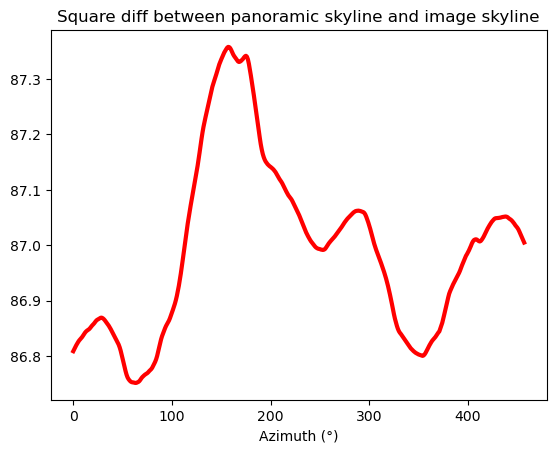

In [133]:
import matplotlib.pyplot as plt
plt.plot(sqd, linewidth=3, color='red')
plt.title('Square diff between panoramic skyline and image skyline')
plt.xlabel('Azimuth (°)')
plt.show()

## Retrieve view at given azimuth
In this example, the correct azimuth is more around 225°.  
The error is explainable: the image has far mountains that are not visible in the point cloud.  

In [81]:
azimuth=221

In [134]:
parameters.extrinsic = camera.get_extrinsic(azimuth, view_point)

In [157]:
camera.visualize([pc, pc2], parameters)

## Retrieve coordinates from depth map

In [100]:
# load depth previously saved, but can later be done automatically from extrinsic parameters corresponding to a specific azimuth
depths = np.load('./data/plots/test_depth.npy')
param = o3d.io.read_pinhole_camera_parameters('./data/plots/test_parameters.json')

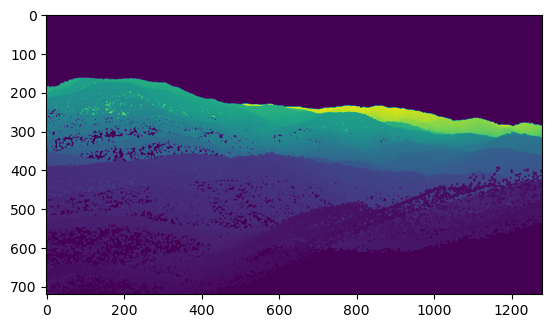

In [101]:
plt.imshow(depths)
plt.show()
# need to fill the gaps between points

In [102]:
u = 115
v = 420
x,y,z = project.unproject(u,v,depths[v,u], param)

In [103]:
project.to_lat_lon(x, y, z)

array([ 44.5542143 ,   4.21658962, 733.75019536])